# Training linear model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

fname = 'train.csv'
data = pd.read_csv('preprocessed2_' + fname, index_col='Id')
n_examples, n_features = data.shape

X, y = data.drop(columns=['SalePrice']), data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1080, 33), (361, 33), (1080,), (361,))

In [2]:
# generate polynomial features

def generate_polynomial(data):
    lst = ['OverallQual', 'SalePriceOfNeighbours', 'GrLivArea',
           'GarageRating', 'YearBuilt',
           'FireplacesRating', 'KitchensRating', 'BsmtQuartersQ',
           'LotFrontage', 'LotArea']
    for feat in lst:
        for degree in [0.5, 1, 2, 3]:
            data[feat + ' ^ ' + str(degree)] = data[feat]**degree
    return data

X_train = generate_polynomial(X_train)

# apply normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


# the same for test set
X_test = generate_polynomial(X_test)
X_test = scaler.transform(X_test)

<ipython-input-2-e8524c45a7fa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feat + ' ^ ' + str(degree)] = data[feat]**degree
<ipython-input-2-e8524c45a7fa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feat + ' ^ ' + str(degree)] = data[feat]**degree


# Training ElasticNet

In [3]:
from sklearn.linear_model import ElasticNet, Lasso
model = ElasticNet(max_iter=10000).fit(X_train, y_train)


In [4]:
# score
from sklearn.metrics import mean_squared_error

print('R^2 score on train = {:.2e}'.format(model.score(X_train, y_train)))
print('R^2 score on test = {:.2e}'.format(model.score(X_train, y_train)))

y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print('MSE on train = {:.2e}'.format(mse))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE on test = {:.2e}'.format(mse))

R^2 score on train = 0.00e+00
R^2 score on test = 0.00e+00
MSE on train = 1.48e-01
MSE on test = 1.42e-01


count    1.08e+03
mean     5.10e-16
std      3.86e-01
min     -1.30e+00
25%     -2.35e-01
50%      2.95e-02
75%      2.49e-01
max      1.13e+00
Name: SalePrice, dtype: float64


Text(0.5, 1.0, 'Residuals, train set \n Score = 0.00e+00')

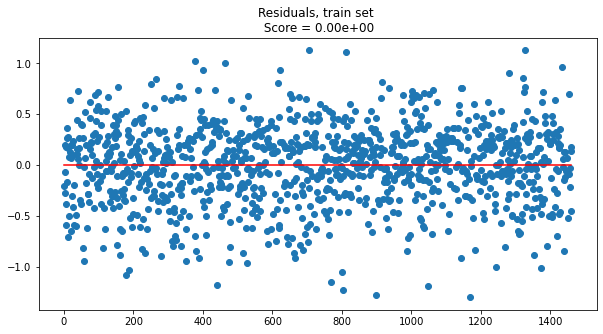

In [5]:
%matplotlib inline
pd.set_option('precision', 2)

residuals = model.predict(X_train) - y_train
print(residuals.describe())

plt.figure(figsize=(10, 5))
plt.scatter(residuals.index, residuals)
plt.plot([0, residuals.index.max()], [0, 0], color='red');
plt.title('Residuals, train set \n Score = {:.2e}'.format(model.score(X_train, y_train)))


count    361.00
mean       0.05
std        0.37
min       -0.98
25%       -0.20
50%        0.06
75%        0.29
max        1.17
Name: SalePrice, dtype: float64


Text(0.5, 1.0, 'Residuals, test set \n Score = -1.55e-02')

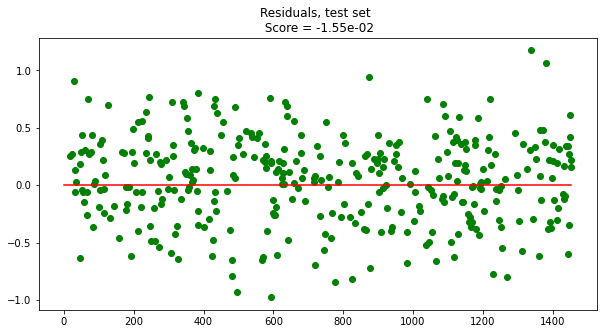

In [6]:
residuals = model.predict(X_test) - y_test
print(residuals.describe())

plt.figure(figsize=(10, 5))
plt.scatter(residuals.index, residuals, color='green')
plt.plot([0, residuals.index.max()], [0, 0], color='red');
plt.title('Residuals, test set \n Score = {:.2e}'.format(model.score(X_test, y_test)))


# Tuning regularization parameters

{'alpha': 0.2, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 10000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


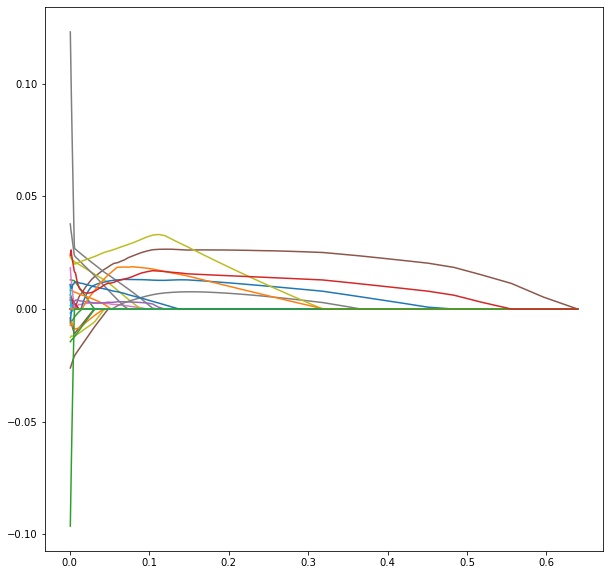

In [7]:
from sklearn.linear_model import ElasticNet, LinearRegression
model = ElasticNet(alpha=0.2, max_iter=10000).fit(X_train, y_train)

alphas, coefs, _ = model.path(X_train, y_train)
plt.figure(figsize=(10, 10))
for i in range(n_features):
    ax = plt.gca()
    ax.plot(alphas, coefs[i, :]);
    
# coefs.max()
# alphas.min(), alphas.max()
print(model.get_params())

In [8]:
# score
from sklearn.metrics import mean_squared_error, make_scorer

def print_score(model):
    print(model)
    print('R^2 score on train = {:.2e}'.format(model.score(X_train, y_train)))
    print('R^2 score on test = {:.2e}'.format(model.score(X_train, y_train)))

    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    print('MSE on train = {:.2e}'.format(mse))

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print('MSE on test = {:.2e}'.format(mse))
    
print_score(LinearRegression().fit(X_train, y_train))
print()
print_score(ElasticNet(alpha=0.2, l1_ratio=0).fit(X_train, y_train))
# print()
# print_score(ElasticNet(alpha=0.1).fit(X_train, y_train))
# print()
# print_score(ElasticNet(alpha=0.2, l1_ratio=1).fit(X_train, y_train))

LinearRegression()
R^2 score on train = 9.24e-01
R^2 score on test = 9.24e-01
MSE on train = 1.13e-02
MSE on test = 1.77e-02

ElasticNet(alpha=0.2, l1_ratio=0)
R^2 score on train = 9.10e-01
R^2 score on test = 9.10e-01
MSE on train = 1.34e-02
MSE on test = 1.80e-02


/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.44975908361354, tolerance: 0.01603736047427928
  model = cd_fast.enet_coordinate_descent(


In [9]:
# # choosing the best alpha
# from sklearn.model_selection import validation_curve
# alphas = np.linspace(0, 1, 50)
# train_scores, test_scores = validation_curve(ElasticNet(l1_ratio=0, max_iter=1000),
#                                              X_train, y_train,
#                                              param_name="alpha", 
#                                              param_range=alphas,
#                                              scoring=make_scorer(mean_squared_error))

In [10]:
# # train_scores = 
# # # train_scores
# # test_scores = )
# plt.figure(figsize=(10, 10))
# plt.plot(alphas, train_scores.mean(axis=1), label='train')
# plt.plot(alphas, test_scores.mean(axis=1), label='test')
# plt.legend()

# Training on entire dataset

In [11]:
X, y = data.drop(columns=['SalePrice']), data['SalePrice']
X = generate_polynomial(X)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

model = LinearRegression().fit(X, y)
# mean_squared_error(y, model.predict(X))
np.sqrt(mean_squared_error(y, model.predict(X)))
# data.shape

data.columns

Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'Utilities', 'OverallQual',
       'YearBuilt', 'TotalBsmtSF', 'CentralAir', 'Electrical', 'GrLivArea',
       'PavedDrive', 'EnclosedPorch', 'PoolArea', 'Fence', 'SalePrice',
       'SaleCondition_Abnorml', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'MSZoning_C (all)', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'NearArtery_or_Feedr', 'PositiveFeat',
       'BsmtQuartersQ', 'DeductionsFunctional', 'RegularityOfShape',
       'SalePriceOfNeighbours', 'TotBath', 'KitchensRating',
       'FireplacesRating', 'GarageRating', 'HasBasement'],
      dtype='object')

# Submitting

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

fname = 'test.csv'
data = pd.read_csv('preprocessed2_' + fname, index_col='Id')
n_examples, n_features = data.shape
X=data

def generate_polynomial(data):
    lst = ['OverallQual', 'SalePriceOfNeighbours_x', 'GrLivArea',
           'GarageRating', 'YearBuilt',
           'FireplacesRating', 'KitchensRating', 'BsmtQuartersQ',
           'LotFrontage', 'LotArea']
    for feat in lst:
        for degree in [0.5, 1, 2, 3]:
            data[feat + ' ^ ' + str(degree)] = data[feat]**degree
    return data

X = generate_polynomial(X)
X = X.fillna(0)
print(pd.isna(X).sum().sort_values())

X = scaler.transform(X)
y_pred = model.predict(X)
ser = pd.Series(np.exp(y_pred), index=data.index)
ser.to_csv('subm.csv')

LotFrontage         0
YearBuilt ^ 2       0
YearBuilt ^ 1       0
YearBuilt ^ 0.5     0
GarageRating ^ 3    0
                   ..
MSZoning_RM         0
MSZoning_RL         0
MSZoning_RH         0
OverallQual ^ 2     0
LotArea ^ 3         0
Length: 73, dtype: int64
